In [21]:
import zipfile
import os
import pathlib
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import tensorflow_hub as hub
import tf_keras


def extract_data_zip(zip_file):
    zip_folder = zip_file.replace('.zip','')
    if not(os.path.exists(zip_folder)):
        zip_ref = zipfile.ZipFile(zip_file)
        zip_ref.extractall()
        zip_ref.close()
        print(zip_file,'extracted succesfully!')
    else:
        print(zip_file,'already extracted!')

def walkthrough_data(data_folder):
    for dirpath, dirnames, filenames in os.walk(data_folder):
        print(dirpath,dirnames,len(filenames))
        
def get_class_names(train_dir):
    data_dir = pathlib.Path(train_dir)
    np_class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
    list_class_names = [item.name for item in data_dir.glob('*')]
    return np_class_names,list_class_names

def view_random_image(target_dir,target_class):
    target_path = os.path.join(target_dir,target_class)    
    
    if os.path.exists(target_path):        
        random_image_path = os.path.join(target_path,random.sample(os.listdir(target_path),1)[0])
        img = mpimg.imread(random_image_path)
        plt.title(target_class)
        plt.imshow(img)
        plt.axis('off')
        print(f'Image Shape : {img.shape}')
        return img
    else: 
        print('Error : ',target_path,' path does not exist')
        return None
    
def process_data(train_dir,test_dir,augmented=False):
    tf.random.set_seed(32)
    if augmented:
        train_data_gen = ImageDataGenerator(rescale=1./255,rotation_range=0.2,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True)
    else:
        train_data_gen = ImageDataGenerator(rescale=1./255)
    test_data_gen = ImageDataGenerator(rescale=1./255)    

    # flow_from_dataframe to load images from dataframe
    train_data = train_data_gen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),class_mode='categorical',seed=32)
    test_data = test_data_gen.flow_from_directory(directory=test_dir, batch_size=32,target_size=(224,224),class_mode='categorical',seed=32)
    return train_data,test_data

def process_image_data(train_dir,test_dir,augmented=False):
    tf.random.set_seed(32)
    train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                     image_size=(224,224),
                                                                     label_mode='categorical', 
                                                                     batch_size=32)
    test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                    image_size=(224,224),
                                                                    label_mode='categorical',
                                                                    batch_size=32)
    return train_data,test_data

def view_accurracy_loss(hist_model,model_name):
    df_eval = pd.DataFrame(hist_model.history)
    df_eval_accurracy = df_eval[['accuracy','val_accuracy']]
    df_eval_loss = df_eval[['loss','val_loss']]
    df_eval_accurracy.plot(title= model_name + '- Accuracy')
    df_eval_loss.plot(title= model_name + ' - Loss')
    
def load_and_prep_image(file_name,img_shape=224):
    img = tf.io.read_file(file_name)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img,size=[img_shape,img_shape])
    img = img/255
    plt.imshow(img)
    return img

def create_tenosrboard_callback(dir_name,exp_name):
    log_dir = dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf_keras.callbacks.TensorBoard(log_dir=log_dir)
    print('Saving Tensorboard log files to -> ',log_dir)
    return tensorboard_callback

def create_transfer_learning_model(model_url,no_classes=10):
    feature_extraction_layer = hub.KerasLayer(model_url,trainable=False,
                                              name='feature_extraction_layer',
                                              input_shape=(224,224,3))
    model = tf_keras.Sequential([
        feature_extraction_layer,
        tf_keras.layers.Dense(no_classes,activation='softmax',name='output_layer'),
    ])
    return model

In [17]:
xip_file = '10_food_classes_all_data.zip'
extract_data_zip(xip_file)
#walkthrough_data('10_food_classes_all_data')
train_dir = os.path.join('10_food_classes_all_data','train')
test_dir = os.path.join('10_food_classes_all_data','test')

10_food_classes_all_data.zip already extracted!


In [18]:
np_class_names,list_class_names = get_class_names(train_dir)
random.choice(np_class_names)

'ice_cream'

Image Shape : (512, 384, 3)


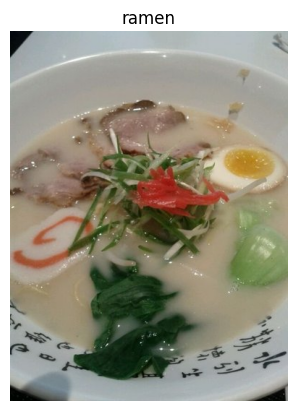

In [19]:
img = view_random_image(target_dir=train_dir,target_class=random.choice(np_class_names))

In [22]:
train_data,test_data = process_data(train_dir,test_dir,augmented=True)
len(train_data),len(test_data)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


(235, 79)

In [23]:
train_data,test_data = process_image_data(train_dir,test_dir)
len(train_data),len(test_data)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


(235, 79)

In [ ]:
img = load_and_prep_image('test_data/03-rice.jpg')

In [ ]:
create_tenosrboard_callback('tensorflow_hub','resnet_50')

In [14]:
resnet_model_url = 'https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/classification/1'
resnet_model = create_transfer_learning_model(resnet_model_url,10)

In [15]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              25612201  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25622221 (97.74 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________
